In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt

import Levenshtein

import sys
sys.path.append('..')
from lib import *

plt.style.use('../peptidome.mplstyle')

/home/andreas/mambaforge/envs/peptidome/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
k = 9

In [3]:
selfset = set(count_kmers_proteome(human, k, clean=True))

In [4]:
# only human host
df_t = load_iedb_tcellepitopes(human_only=True)
print(df_t.shape[0])

248879


In [5]:
# only MHC I epitopes
df_t = df_t[df_t['MHC', 'Class']=='I']
print(df_t.shape[0])

69747


In [6]:
# only epitopes of lengths in k
mask = df_t['Epitope', 'Description'].apply(len)==k
df_t = df_t[mask]
print(df_t.shape[0])

37813


In [7]:
# no host epitopes
host = 'Homo sapiens'
mask = ~df_t['Epitope', 'Parent Species'].str.contains(host, na=False)
df_t = df_t[mask]
print(df_t.shape[0])

33091


In [8]:
# exclude autoimmune / allergy / cancer epitopes
mask = ~(df_t['1st in vivo Process', 'Process Type'].isin(['Occurrence of autoimmune disease', 
                                                           'Occurrence of allergy',
                                                           'Occurrence of cancer']))
df_t = df_t[mask]
print(df_t.shape[0])

31281


In [9]:
df_t['Assay', 'Method/Technique'].value_counts().head(10)

ELISPOT                            18972
multimer/tetramer                   3171
ICS                                 2961
51 chromium                         2260
ELISA                               1073
biological activity                  967
in vitro assay                       714
binding assay                        253
surface plasmon resonance (SPR)      248
CFSE                                 143
Name: (Assay, Method/Technique), dtype: int64

In [63]:
df_t['Assay', 'Method/Technique'].value_counts().head(1)/len(df_t)

ELISPOT    0.606502
Name: (Assay, Method/Technique), dtype: float64

In [28]:
assay_counts = df_t['Assay', 'Method/Technique'].value_counts().head(5)

In [10]:
# exclude rare assay types
mask = df_t[('Assay', 'Method/Technique')].isin(df_t[('Assay', 'Method/Technique')].value_counts().head(5).index)
df_t_f = df_t[mask]

In [11]:
d0 = df_t_f['Epitope', 'Description'].apply(lambda x: x in selfset)

In [12]:
df_t_f[d0]['Epitope', 'Parent Species'].value_counts()

Vaccinia virus                68
Mus musculus                   2
Leishmania major               2
Human betaherpesvirus 5        1
Human betaherpesvirus 6B       1
Dengue virus                   1
Mycobacterium tuberculosis     1
Name: (Epitope, Parent Species), dtype: int64

In [13]:
pos_d0 = df_t_f[d0][[('Assay', 'Method/Technique'),
                     ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')
pos_d0_count = df_t_f[d0][[('Assay', 'Method/Technique'),
                     ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('count')

In [14]:
pos_all = df_t_f[[('Assay', 'Method/Technique'),
                  ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')
pos_all_count = df_t_f[[('Assay', 'Method/Technique'),
                  ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('count')

In [51]:
dfm = pd.merge(pos_d0, pos_all, how='inner', left_index=True, right_index=True, suffixes=['_d0', '_all'])
dfm = dfm.loc[assay_counts.index]

In [52]:
px = dfm['Assay_all', 'Positive']
py = dfm['Assay_d0', 'Positive']
ny = pos_d0_count.loc[px.index]['Assay', 'Positive']
nx = pos_all_count.loc[py.index]['Assay', 'Positive']

lower_x, upper_x = statsmodels.stats.proportion.proportion_confint(px*nx, nx, method='jeffreys', alpha=.1)
xerr = (px-lower_x, upper_x-px)
lower_y, upper_y = statsmodels.stats.proportion.proportion_confint(py*ny, ny, method='jeffreys', alpha=.1)
yerr = (py-lower_y, upper_y-py)
yerr

(ELISPOT              0.009691
 multimer/tetramer    0.431133
 ICS                 -0.001543
 51 chromium         -0.001543
 ELISA                0.400707
 dtype: float64,
 ELISPOT              0.033294
 multimer/tetramer    0.270921
 ICS                  0.771480
 51 chromium          0.771480
 ELISA                0.203993
 dtype: float64)

In [53]:
dfm = dfm.rename(index={'multimer/tetramer':'multimer'})

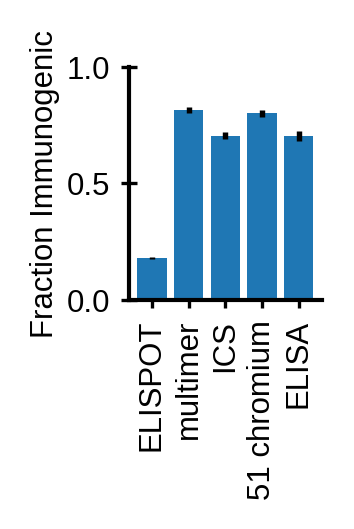

In [66]:
fig, ax = plt.subplots(figsize=(1.25, 1.75))
ax.bar(dfm['Assay_all'].index,
            dfm['Assay_all']['Positive'],
            yerr=xerr)
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('Fraction Immunogenic')
fig.tight_layout()
fig.savefig(figuredir + 'iedb_assays.svg')

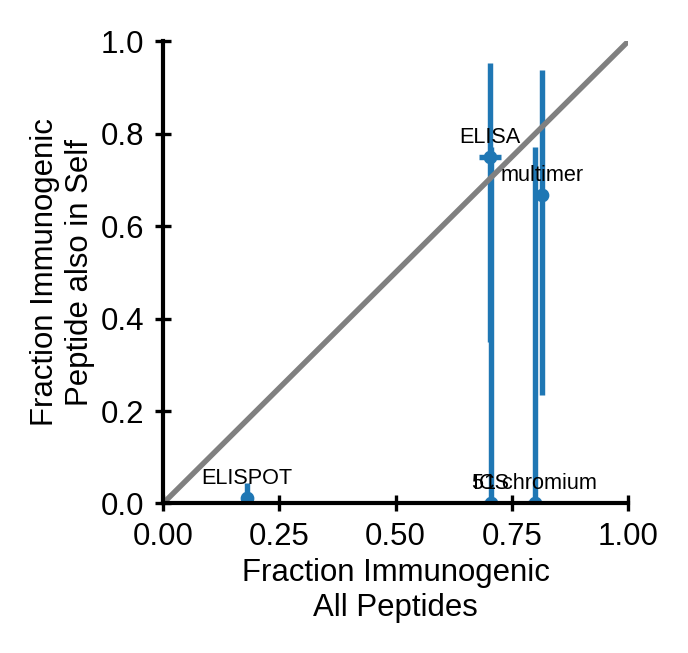

In [17]:
fig, ax = plt.subplots(figsize=(2, 2))
labels = dfm.index
ax.errorbar(px, py, yerr=yerr, xerr=xerr, fmt='o')

for x, y, label in zip(px, py, labels):
    plt.annotate(label.split('/')[0], (x, y+0.02),
                 ha='center', va='bottom', size='xx-small')

plt.plot([0, 1], [0, 1], '-', c='.5')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Fraction Immunogenic\nAll Peptides')
plt.ylabel('Fraction Immunogenic\nPeptide also in Self')
fig.savefig(figuredir + 'assays.svg')